# Credit Curves Comparison between Issuers

This third notebook in Credit Curves SDK series is built upon the Fundamentals Template and demonstrates advanced **issuer spread analysis** (between Netherlands and Germany) within the **LSEG Financial Analytics SDK**. 


**You will be able to:**
- Define Credit Curve with basic parameters 
- Adjust the Issuer
- Analyze the Spread between Credit Curves of different Issuers

## Imports

Import the following necessary modules:

- `lseg_analytics.pricing.market_data` - for Credit Curve data construction

This notebook uses external libraries **pandas, matplotlib, IPython**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.market_data import credit_curves as cc

import pandas as pd
import json
import datetime as dt
from IPython.display import display
import matplotlib.pyplot as plt

## Data Preparation and Request Execution

To define a Credit Curve instrument you need to follow a process:

1. **Credit Curve Definition** - Specify Issuer parameters (Issuer, Issuer Type, Country, Currency)
2. **Credit Curve Parameters** - Specify Curve parameters (Date, Calibration Model, Calibration Parameters)
3. **Request Creation** - Combine definition and parameters into a request object

### Netherlands Government curve

In [2]:
print("Step 1: Configuring Curve Definition...")

country_base = "NL"
currency = "EUR"
curve_definition = cc.CreditCurveDefinition(
    name = "Netherlands GOV Par Benchmark Curve", # combination of Name | Country | Currency | isCurrencyCountryOriginator, see Appendix 2 in 1_CreditCurves_SDK_Fundamentals for the full list
    issuer_type = cc.IssuerTypeEnum.SOVEREIGN,
    country = country_base,
    source = cc.RatingScaleSourceEnum.REFINITIV,
    currency = currency,
    curve_sub_type=cc.CurveSubTypeEnum.GOVERNMENT_BENCHMARK,
    is_currency_country_originator=True
)

print("Step 2: Configuring Curve Parameters...")

curve_parameters = cc.CreditCurveParameters(
    valuation_date = dt.date(2025, 9, 19),
    calibration_model = cc.CalibrationModelEnum.BASIS_SPLINE,
    calibration_parameters = cc.CalibrationParameters(
        is_monotonic = False,
        extrapolation_points_number = 4,
        extrapolation_type = cc.ExtrapolationTypeEnum.EXTRAPOLATION_BOTH_DERIVATIVE
    ),
    use_duration_weighted_minimization = True,
    use_multi_dimensional_solver = True,
    calendar_adjustment = cc.CalendarAdjustmentEnum.CALENDAR,
    use_delayed_data_if_denied = False
)


print("Step 3: Create request item...")

credit_curve_request = cc.CreditCurveRequestItem(
    curve_parameters = curve_parameters,
    curve_definition = curve_definition,
    constituents = None
)

print(f"   Request: {json.dumps(credit_curve_request.as_dict(), indent=4)}")

Step 1: Configuring Curve Definition...
Step 2: Configuring Curve Parameters...
Step 3: Create request item...
   Request: {
    "curveParameters": {
        "valuationDate": "2025-09-19",
        "calibrationModel": "BasisSpline",
        "calibrationParameters": {
            "isMonotonic": false,
            "extrapolationPointsNumber": 4,
            "extrapolationType": "ExtrapolationBothDerivative"
        },
        "useDurationWeightedMinimization": true,
        "useMultiDimensionalSolver": true,
        "calendarAdjustment": "Calendar",
        "useDelayedDataIfDenied": false
    },
    "curveDefinition": {
        "name": "Netherlands GOV Par Benchmark Curve",
        "issuerType": "Sovereign",
        "country": "NL",
        "source": "Refinitiv",
        "currency": "EUR",
        "curveSubType": "GovernmentBenchmark",
        "isCurrencyCountryOriginator": true
    }
}


In [3]:
print(f"Calculating Credit Curve for {curve_definition.name}...")
# Execute the credit curve calculation using cc.calculate
# The 'universe' parameter accepts a list of request items for batch processing
try:
    response_netherlands = cc.calculate(universe=[credit_curve_request])
    print("Credit curve calculation completed")
except Exception as e:
    print("Error during credit curve calculation:", str(e))

Calculating Credit Curve for Netherlands GOV Par Benchmark Curve...
Credit curve calculation completed


### Germany Government curve

In order to get the Credit Curve with different country, adjust the Name, Country and Currency Country Originator in Parameters section and recalculate the Curve

In [4]:
print("Adjusting Curve Definition...")

country_compare = "DE"
curve_definition.name = "Germany GOV Par Benchmark Curve"
curve_definition.country = country_compare
curve_definition.is_currency_country_originator = True

credit_curve_request = cc.CreditCurveRequestItem(
    curve_parameters = curve_parameters,
    curve_definition = curve_definition,
    constituents = None
)

print(f"   Request: {json.dumps(credit_curve_request.as_dict(), indent=4)}")


Adjusting Curve Definition...
   Request: {
    "curveParameters": {
        "valuationDate": "2025-09-19",
        "calibrationModel": "BasisSpline",
        "calibrationParameters": {
            "isMonotonic": false,
            "extrapolationPointsNumber": 4,
            "extrapolationType": "ExtrapolationBothDerivative"
        },
        "useDurationWeightedMinimization": true,
        "useMultiDimensionalSolver": true,
        "calendarAdjustment": "Calendar",
        "useDelayedDataIfDenied": false
    },
    "curveDefinition": {
        "name": "Germany GOV Par Benchmark Curve",
        "issuerType": "Sovereign",
        "country": "DE",
        "source": "Refinitiv",
        "currency": "EUR",
        "curveSubType": "GovernmentBenchmark",
        "isCurrencyCountryOriginator": true
    }
}


In [5]:
print(f"Calculating Credit Curve for {curve_definition.name}...")
try:
    response_germany = cc.calculate(universe=[credit_curve_request])
    print("Credit curve calculation completed")
except Exception as e:
    print("Error during credit curve calculation:", str(e))

Calculating Credit Curve for Germany GOV Par Benchmark Curve...
Credit curve calculation completed


## Results Display

We compare below the Netherlands and Germany government credit curves with a root mean squared error (RMSE) and a mean error on curves, as well as a dataframe and a plot representing and comparing curve rates

In [6]:
# Format data and join the two curve DataFrames on 'Tenor' and calculate the difference in RatePercent

def respone_to_df_and_info(response):
    # Load JSON response
    response_json = json.loads(json.dumps(response.as_dict()))

    name = response_json["data"][0]["curveDefinition"]["name"]

    valuation_date = dt.datetime.strptime(response_json["data"][0]["curveParameters"]['valuationDate'], '%Y-%m-%d').date()

    # Collecting results to DataFrame
    curve_points = response_json["data"][0]["curvePoints"]
    rate_vs_tenor = [(point["tenor"], point["ratePercent"]) for point in curve_points]
    rate_vs_tenor_df = pd.DataFrame(rate_vs_tenor, columns=["Tenor", "RatePercent"])
    return rate_vs_tenor_df, name, valuation_date

rate_vs_tenor_df_base, name_base, valuation_date= respone_to_df_and_info(response_netherlands)
rate_vs_tenor_df_compare, name_compare, _ = respone_to_df_and_info(response_germany)

rate_vs_tenor_df_base['RatePercent'] = rate_vs_tenor_df_base['RatePercent'].round(2)
rate_vs_tenor_df_compare['RatePercent'] = rate_vs_tenor_df_compare['RatePercent'].round(2)
joined_df = pd.merge(
    rate_vs_tenor_df_base,
    rate_vs_tenor_df_compare,
    on='Tenor',
    suffixes=(f'_{country_base}', f'_{country_compare}')
)

In [7]:
# Computing the RMSE and Mean Error between Netherlands and Germany issuers

col_name_base = f'RatePercent_{country_base}'
col_name_compare = f'RatePercent_{country_compare}'

joined_df['RatePercent_Diff'] = (joined_df[col_name_base] - joined_df[col_name_compare]).round(2)

rmse = ((joined_df[col_name_base] - joined_df[col_name_compare])**2).mean() ** 0.5
mean_error = (joined_df[col_name_base] - joined_df[col_name_compare]).mean()
print(f"Root Mean Squared Rate Error (RMSE) between {name_base} and {name_compare}: {round(100*rmse)} bp")
print(f"Mean Difference between {name_base} and {name_compare}: {round(100*mean_error)} bp")

Root Mean Squared Rate Error (RMSE) between Netherlands GOV Par Benchmark Curve and Germany GOV Par Benchmark Curve: 14 bp
Mean Difference between Netherlands GOV Par Benchmark Curve and Germany GOV Par Benchmark Curve: 13 bp


,Tenor,RatePercent_NL,RatePercent_DE,RatePercent_Diff
0,3M,2.00,1.89,0.11
1,6M,2.01,1.94,0.07
2,1Y,2.02,1.95,0.07
3,2Y,2.07,1.99,0.08
4,3Y,2.18,2.08,0.10
5,4Y,2.31,2.20,0.11
6,5Y,2.44,2.30,0.14
7,6Y,2.55,2.40,0.15
8,7Y,2.65,2.49,0.16
9,8Y,2.76,2.59,0.17


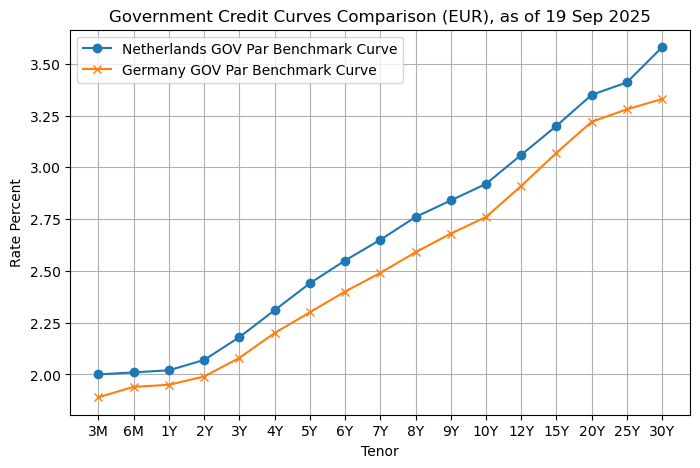

In [8]:
# Display results to compare Netherlands and Germany issuers

display(joined_df)

valuation_date_str = valuation_date.strftime('%d %b %Y')
plt.figure(figsize=(8,5))
plt.plot(rate_vs_tenor_df_base['Tenor'], rate_vs_tenor_df_base['RatePercent'], marker='o', label=f'{name_base}')
plt.plot(rate_vs_tenor_df_compare['Tenor'], rate_vs_tenor_df_compare['RatePercent'], marker='x', label=f'{name_compare}')
plt.title(f"Government Credit Curves Comparison ({currency}), as of {valuation_date_str}")
plt.xlabel('Tenor')
plt.ylabel('Rate Percent')
plt.grid(True)
plt.legend()
plt.show()